## Bibliotecas

In [89]:
import librosa 
import numpy as np
from math import pi,sin,cos
import scipy
from matplotlib import pyplot as plt
import librosa.display 

## Fingerprinting e Relacionados

In [80]:
def fingerprint(samples, sampling_rate,  channels=2, max_length=0)->np.ndarray:
    
    samples_per_window = int(sampling_rate*0.037) # Quantas samples por window 
    num_timeframes = int(max_length/samples_per_window) # Descobre quantos frames 
    num_bands = 25 # 25 bandas, segundo o artigo
    
    fngrprnt = np.empty([channels,num_timeframes-1,num_bands-1],dtype=int) #Declarando o fingerprint
    for k,ch in enumerate(samples):
        
        add_zero = num_timeframes - (max_length % num_timeframes) #Calculando quantos zeros serão 
                                                                  # necessários para um split exato

        ch = np.append(ch,np.zeros(add_zero)) #Adicionando os zeros necessários
        
        windows = np.split(ch,num_timeframes) #Dividindo a track em frames
    
        fft_windows = np.empty(np.shape(windows), dtype=complex) #Criando array que receberá as transformadas
        
        for i,window in enumerate(windows):
            fft_windows[i] = scipy.fft.fft(window) #Montando os frames transformados
           

        len_frame = int(len(ch)/num_timeframes)
        add_bands_zero = num_bands - (len_frame % num_bands)#Calculando quantos zeros serão 
                                                            # necessários para um split exato
        timeframe_bands = np.empty([num_timeframes,num_bands]) #Criando array que receberá as transformadas
        for j,fft_window in enumerate(fft_windows):
            aux = np.split(np.append(fft_window,np.zeros(add_bands_zero,dtype=complex)),num_bands) # Adicionando os zeros 
                                                                                     #necessários e splitando
            timeframe_bands[j] = average(aux) #Tirando a média de cada banda de energia e montando o array 
        
        ch_fngrprnt = treat(timeframe_bands) # Gerando o fingerprint em si a partir das bandas

        fngrprnt[k] = ch_fngrprnt #Montando o fingerprint do canal k 
    
    return fngrprnt        

In [103]:
def treat(timeframe_bands)->np.ndarray:
    bands = len(timeframe_bands[0]) -1#24
    ch_fprint = np.empty([len(timeframe_bands),bands],dtype=int)
    bands_frame_anterior = np.zeros(bands)
    aux = np.empty(bands)
    for j,frame in enumerate(timeframe_bands):
        
        for i in range(len(frame)-1):
            aux[i] = frame[i] - frame[i+1]
            
            if(aux[i]>bands_frame_anterior[i]):
                ch_fprint[j][i] = 1
            else: 
                ch_fprint[j][i] = -1
            bands_frame_anterior[i] = aux[i]
    
    
     
    return ch_fprint[1:]

In [105]:
def average(array_freq):
    soma = 0.
    aux = np.empty([len(array_freq),])
    for j,ary in enumerate(array_freq):
        for i in ary:
            soma += abs(i)**2 #Energia em nessa frequencia
        aux[j] = soma

    return aux

## FFT de Rodrigo

In [83]:
def fft(f,N)->list:

    # if there is only one item in the array, return THE ARRAY
    if N <= 1:
        return f

    # generate inverted roots of unit (remember the formula of the terms)
    theta = -2*pi/N
    w = list( complex(cos(theta*k),sin(theta*k))  for k in range(N) ) 
    
    # separate even and odd coefficients
    Ceven = fft(f[0::2],N//2)
    Codd =  fft(f[1::2],N//2)
    
    # array to hold the coefficients
    C = [0]*N

    # middle of the array
    middle = N//2
    for k in range(middle):
        c_even   =    Ceven[k]
        w_c_odd  =  w[k]*Codd[k]
        
        C[k]          = c_even + w_c_odd
        C[k + middle] = c_even - w_c_odd

    return C

## DFT que eu fiz baseada na FFT de Rodrigo

In [84]:
def dft(f,time_samples,freq_samples)->list:


    # generate inverted roots of unit (remember the formula of the terms)
    theta = -2*pi/time_samples
    w = list( list(complex(cos(theta*u*k),sin(theta*u*k)) for k in range(time_samples)) for u in range(freq_samples)) 
    
    C = [0]*freq_samples

    for u in range(freq_samples):
        for k in range(time_samples):
            C[u] += f[k]*w[u][k]/time_samples

    return C

## Código feito por Rodrigo para plotar a fft

In [85]:
def plot_transform(samples,coeff = None, coeff2 = None):
    if coeff is None and coeff2 is None:
        coeff = fft(samples,len(samples))
        coeff2 = dft(samples,len(samples),len(samples))
        
    N = len(coeff)
    coeff = list(abs(Complex)/N for Complex in coeff)
    coeff2 = list(abs(Complex)/N for Complex in coeff2)

    
    figura = plt.figure(num=None, figsize=(10, 2), dpi=360, facecolor='w', edgecolor='k')
    ax = figura.add_axes([0,0,1,1])
    
    frequencies = ['cte'] + list( str(i) for i in range(1,N))
    ax.bar(frequencies,coeff)
    plt.show()

    figura2 = plt.figure(num=None, figsize=(10, 2), dpi=360, facecolor='w', edgecolor='k')
    ax = figura2.add_axes([0,0,1,1])
    ax.bar(frequencies,coeff2)
    plt.show()

    figura3 = plt.figure(num=None, figsize=(10, 2), dpi=360, facecolor='w', edgecolor='k')
    ax = figura3.add_axes([0,0,1,1])
    coeff3 = scipy.fft(samples)
    ax.bar(frequencies,coeff3)
    plt.show()

    figura4 = plt.figure(num=None, figsize=(12, 3), dpi=360, facecolor='w', edgecolor='k')
    ax = figura4.add_axes([0,0,1,1])
    ax.bar(list(range(len(samples))), samples)
    plt.show()


## Codigo feito por Rodrigo para gerar uma função periódica

In [86]:
# auxiliar to be an array of y(t) values for some points
# this will help us check if fft works by transforming periodic functions 
class exp:
    def __init__(self,frequency = None):
        self.f = frequency
        if frequency is not None:
            self.function = lambda t: complex(cos(2*pi*frequency*t),sin(2*pi*frequency*t))
        self.measurements = None
        self.N_samples = 32

    def measure(self, N_samples = 32):
        self.N_samples = N_samples
        self.measurements = list(self.function(t) for t in range(N_samples) )
        return  self.measurements
        
    def __add__(self,other):

        if self.measurements is None:
            self.measure()
        if (other.measurements is None) or (self.N_samples == other.N_samples):
            other.measure(self.N_samples)
        
        result = exp()
        result.N_samples = self.N_samples
        result.measurements = [0]*self.N_samples
        result.function = lambda t:( self.function(t) + other.function(t) )

        result.measure()

        return result

## Execução

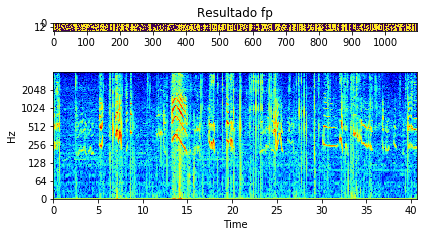

In [104]:
nome = "consegui"
sample, sample_rate = librosa.load(nome +".wav", sr=None, mono=False) #Carrega o arquivo
fing = fingerprint([sample],sample_rate,1,len(sample)) #Faz a fingerprint
np.savetxt(nome + ".csv",fing[0],delimiter=',')

plotar = fing[0]
fig, (ax,spec) = plt.subplots(2,1)
im = ax.imshow(plotar.T)

# Show ticks
ax.set_xticks(np.arange(0,1095,step=100))
ax.set_yticks(np.arange(0,24,step=12))

FRAME_SIZE = 2048
HOP_SIZE = 512

data_1D = librosa.stft(sample, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)    
Y_scale = np.abs(data_1D)**2
Y_scale = librosa.power_to_db(Y_scale,ref=np.max)
librosa.display.specshow(Y_scale,sr=sample_rate, hop_length=HOP_SIZE, x_axis="time", y_axis="log",cmap=plt.cm.jet)

ax.set_title("Resultado fp")
librosa.display.specshow(Y_scale,sr=sample_rate, x_axis="time", y_axis="log",cmap=plt.cm.jet)
fig.tight_layout()
plt.show()
fig.savefig(nome + ".png", format="png")
